# Academic Notebook

**NOTICE**

**To meen the requirement that all datafile will be less than 10MB, we trancated our dataset, so the results may be different from our report. If you want to see the full version, please use the CoLab below.**

https://colab.research.google.com/drive/194WWfGNLpiOLRp-hD_T07Fz7HeX1gkOo#scrollTo=48e3cd34-957a-49f7-a516-bcfafbb33efa

**You can also find our compelete dataset in https://github.com/duowenpu/Milestone-I-BPP, while you need to unzip the dblp.zip in "data\Academic\CSRanking"**

We use the CSranking dataset to estimate the number of pulications of each university and country, and Google scholar dataset to calculate the citations of universities in the United States (some countries cannot use google, so we didn't compare across the globe to avoid bias). Fianlly, Stanford AI report dataset is used to estimate the original works of countries and universities.

## 1 Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import requests
import warnings
import xml.etree.ElementTree as ET
from geopy.extra.rate_limiter import RateLimiter
from ipywidgets import widgets
from ipywidgets import interact
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

import plotly.graph_objects as go
warnings.filterwarnings('ignore')

## 2 Loading Data

In [2]:
df_cs_paper = pd.read_xml('data/Academic/CSranking/dblp2.xml') #The csranking paper dataset
df_csranking = pd.read_csv('data/Academic/CSranking/csrankings.csv') #The csranking author dataset
df_publications = pd.read_csv('data/Academic/GoogleScholar/publications.csv') #The google scholar publication dataset
df_model_name = pd.read_excel('data/Academic/Models/Parameter, Compute and Data Trends in Machine Learning.xlsx') #Get the model dataset
# Get lookup tables. One dataset may have enough inforamtion, so we use different datasets to find country of a university
geolocation = pd.read_csv('data/Academic/LookupTable/geolocation.csv') #Get the latitude and longitude of universities.
names = pd.read_json('data/Academic/LookupTable/world_universities_and_domains.json') #University and scholar name.
country_all = pd.read_csv('data/Academic/LookupTable/all.csv') #University and Country
country_information = pd.read_csv('data/Academic/CSranking/country-info.csv') #University and Country
df_country_cs_ranking = pd.read_csv('data/Academic/CSranking/country-info.csv') #University and Country
df_qs_ranking = pd.read_csv('data/Academic/LookupTable/2023 QS World University Rankings.csv') #University and Country
geo_university = pd.read_csv('data/Academic/LookupTable/timesMergedData.csv') #University and Loaction
temp_country = pd.read_csv('data/Academic/LookupTable/df_model_name_country.csv') #Intermideiate results of the model dataset

## 3 Data Manipulation
### 3.1 Use Email domain and other information to get the university of scholars

In [3]:
# Initialize the univeristy variable as np.nan
df_publications['university'] = np.nan

# Use csranking author dataset to find some scholars' universities
a_name = df_csranking['affiliation'].unique()
count = 0
for name in a_name:
    if (df_publications['university_name'].str.contains(name)).sum()>0:
        df_publications['university'][df_publications['university_name'].str.contains(name)]= name

# Use the email domain to find the universities. A complete match may not be appropriate, 
# as "cs.stanford.edu" and "standford.edu" both belong to Stanford, but the email domain 
# dataset only has the latter. So the university name is constructed if it contains a particular
# email domain, like "stanford.edu." The shorter domain must be matched first, and parallel 
# computation should not be used, so even if "nyu.edu" is recognized as Yeshiva University 
# because it contains "yu.edu," it will be corrected with the for-loop of "nyu.edu."
names_university = []
for i in range(len(names)):
    row = names.iloc[i]
    for domain in row['domains']:
        names_university.append([row['name'], domain])
names_university = pd.DataFrame(names_university, columns = ['name', 'domain'])
names_university['strcount'] = names_university['domain'].apply(len)
names_university = names_university.sort_values(by = 'strcount')

for i in range(len(names_university)):
    idx = df_publications['email_domain'].str.contains(names_university.iloc[i]['domain'])
    idx[idx.isna()] = False
    df_publications['university'][idx] = names_university.iloc[i]['name']

In [4]:
print('The percentage with the university name {}%'.\
      format(str(round((len(df_publications['name'].unique())
                        -len(df_publications['name'][df_publications['university'].isna()].unique()))/
                                                        len(df_publications['name'].unique())*100,2))))

The percentage with the university name 73.55%


### 3.2 Get the country of universities
We will generate a DataFrame to save the corresponding relation between countries and universities.

In [5]:
# Use all.csv in CSRanking, but it only contains some of the universities

country_information['countryabbrv'] = country_information['countryabbrv'].str.upper()
country_information['countryabbrv'] = country_information['countryabbrv'].\
replace(dict(zip(country_all['alpha-2'], country_all['name'])))

We can use scrapping method to get the location of the university. Uncomment the code below to do so. I have write the result to CSV file.

In [6]:
# from bs4 import BeautifulSoup
# def get_location_country(x):
#     url = 'https://nominatim.openstreetmap.org/reverse?lat=' + str(x['latitude']) + '&lon=' + str(x['longitude']) + '&accept-language=de'
#     html = requests.request("Get",url)
#     soup = BeautifulSoup(html.text, 'html.parser')
#     try:
#         return soup.find('country').text
#     except:
#         return None

# geolocation['country'] = geolocation.apply(get_location_country, axis = 1)
# Use longitude and latitude to find the country
# geo_locator = Nominatim(user_agent="getthelocation")
# geolocation = pd.read_csv('geolocation.csv')
# geolocation['country'] = geolocation.apply(lambda x: geo_locator.reverse(str(x['latitude']) + "," + str(x['longitude']), language="en").raw['address'].get('country',''), axis = 1)
# geolocation_name = set(geolocation['institution']).union(set(country_information['institution']))

### 3.3 Filter the csranking datasets so we only include papers in AI

In [7]:
# Define the keywords of data science in the CSRanking dataset

AI = ['ACM', 'SIGAI', 'AAAI', 'IJCAI']
CV = ['CVF','CVPR','ECCV','ICCV']
ML = ['ACM SIGKDD', 'ICLR','IMLS','NEURIPS/NIPS', 'ICLR', 'ICML', 'NeurlPS', 'KDD']
NLP = ['ACL','EMNLP','NAACL']
WIR = ['ACM SIGIR','SIGIR','WWW']
AI_all = ['ACM', 'SIGAI', 'AAAI', 'IJCAI', 'CVF','CVPR','ECCV','ICCV',
          'ACM SIGKDD', 'ICLR','IMLS','NEURIPS/NIPS', 'ICLR', 'ICML', 
          'NeurlPS', 'KDD', 'ACL','EMNLP','NAACL', 'ACM SIGIR','SIGIR','WWW']

#Filter the dataset
df_cs_paper = df_cs_paper[df_cs_paper['booktitle'].isin(AI_all)]

# Get the university name
dict_csranking = dict(zip(df_csranking['name'], df_csranking['affiliation']))
df_cs_paper['university'] = df_cs_paper['author']
df_cs_paper['university'] = df_cs_paper['university'].replace(dict_csranking)

In [8]:
# Use the RSranking dataset to get the country name of universities.
df_qs_ranking['key'] = df_qs_ranking.institution.str.replace(r'\(\w*\)','', regex = True)\
    .str.replace('\W','').str.replace('the','').str.lower()
country_information['key'] = country_information['institution'].str\
    .replace(r'\(\w*\)','', regex = True).str.replace('\W','').str.replace('the','').str.lower()

df_cs_paper['key'] = df_cs_paper['university'].str.replace('Univ.', 'University', regex = False)\
    .str.replace(r'\(\w*\)','', regex = True).str.replace('\W','').str.replace('the','').str.lower()

df_cs_paper = df_cs_paper[df_cs_paper['key'].isin(set(df_qs_ranking['key']).union(set(country_information['key'])))]
df_cs_paper['country'] = df_cs_paper['key']
df_cs_paper['country'] = df_cs_paper['key'].replace(dict(zip(df_qs_ranking['key'], df_qs_ranking['location'])))\
    .replace(dict(zip(country_information['key'], country_information['countryabbrv'])))

df_cs_paper['country'][df_cs_paper['country'] == 'China (Mainland)'] = 'China'
df_cs_paper['country'][df_cs_paper['country'] == 'Korea, Republic of'] = 'South Korea'
df_cs_paper['country'][df_cs_paper['country'] == 'Hong Kong SAR'] = 'Hong Kong'

## 4 Analysis
### 4.1 Publications

In [9]:
# Top 20 Universities' total publications
df_cs_paper.groupby('university').agg('count').sort_values('key', ascending = False)['title'][:20]

university
Peking University                        182
Carnegie Mellon University               175
Tsinghua University                      147
Stanford University                      132
University of Edinburgh                  132
National University of Singapore         118
Chinese Academy of Sciences              118
University of Washington                 116
Harbin Institute of Technology           105
Shanghai Jiao Tong University            101
Nanjing University                        96
Zhejiang University                       96
Columbia University                       94
HKUST                                     94
University of Pennsylvania                93
Massachusetts Institute of Technology     92
University of Maryland - College Park     92
Johns Hopkins University                  91
University of Texas at Austin             89
Univ. of California - Los Angeles         89
Name: title, dtype: int64

Text(0.5, 1.0, 'The Number of Pulications among Universities')

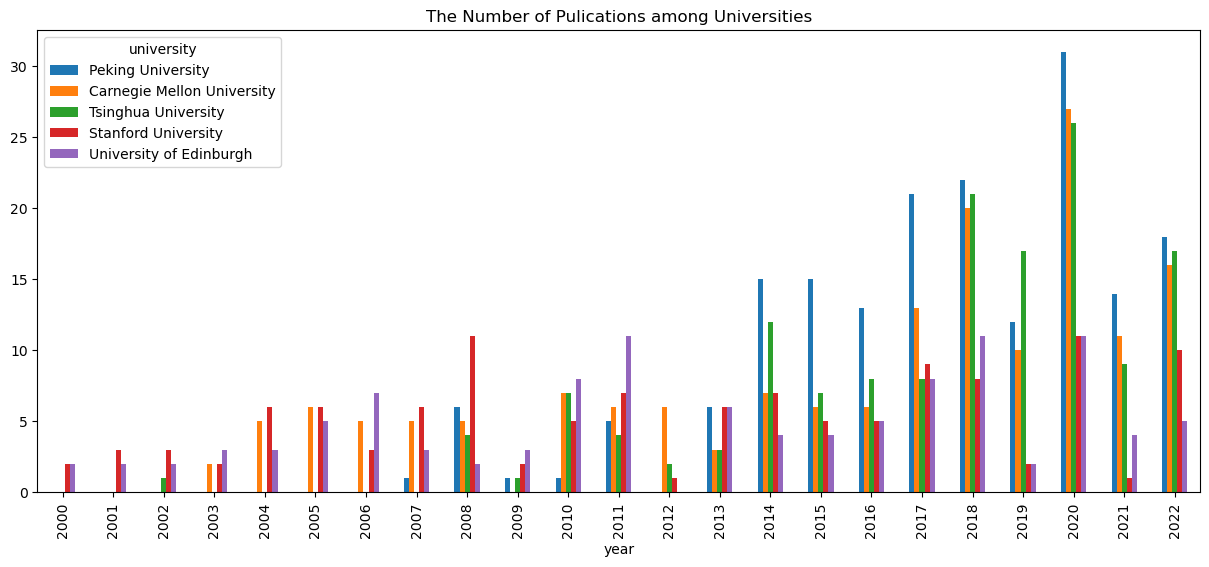

In [10]:
# Publications of each year
df_cs_university = df_cs_paper.groupby(['year','university']).agg('count')\
    .sort_values('key', ascending = False)['key'].reset_index()
df_cs_university['key'] = df_cs_university['key'].astype(int)
df_cs_university = df_cs_university.pivot_table(index = 'university', columns = 'year', values = 'key').fillna(0)

years = [x for x in range(2000,2023)]

fig, ax = plt.subplots(figsize = (15,6))
df_cs_university[years].loc[df_cs_university.sum(axis = 1).sort_values(ascending = False)\
                            .index][:5].transpose().plot.bar(ax = ax)
ax.set_title('The Number of Pulications among Universities')

Text(0.5, 1.0, 'The Number of Pulications among Countries')

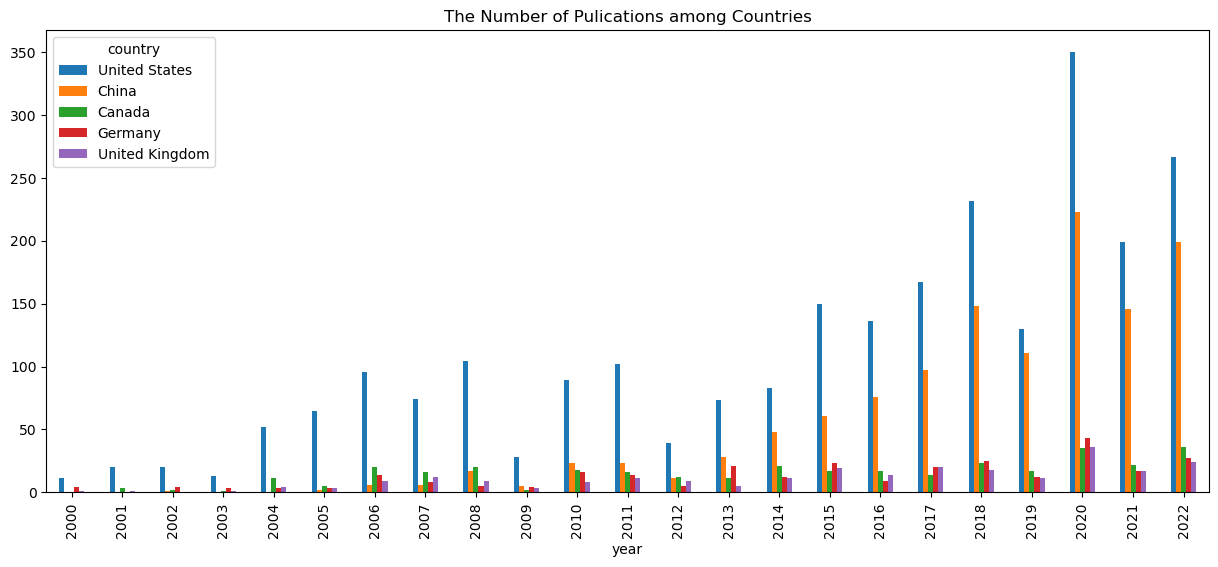

In [11]:
# Publication of each country
fig, ax = plt.subplots(figsize = (15,6))
df_cs_country = df_cs_paper.groupby(['year','country']).agg('count')\
    .sort_values('key', ascending = False)['key'].reset_index()
df_cs_country['key'] = df_cs_country['key'].astype(int)
df_cs_country = df_cs_country.pivot_table(index = 'country', columns = 'year', values = 'key').fillna(0)
df_cs_country[years].loc[df_cs_country.sum(axis = 1)\
                         .sort_values(ascending = False).index][:5].transpose().plot.bar(ax = ax)
ax.set_title('The Number of Pulications among Countries')

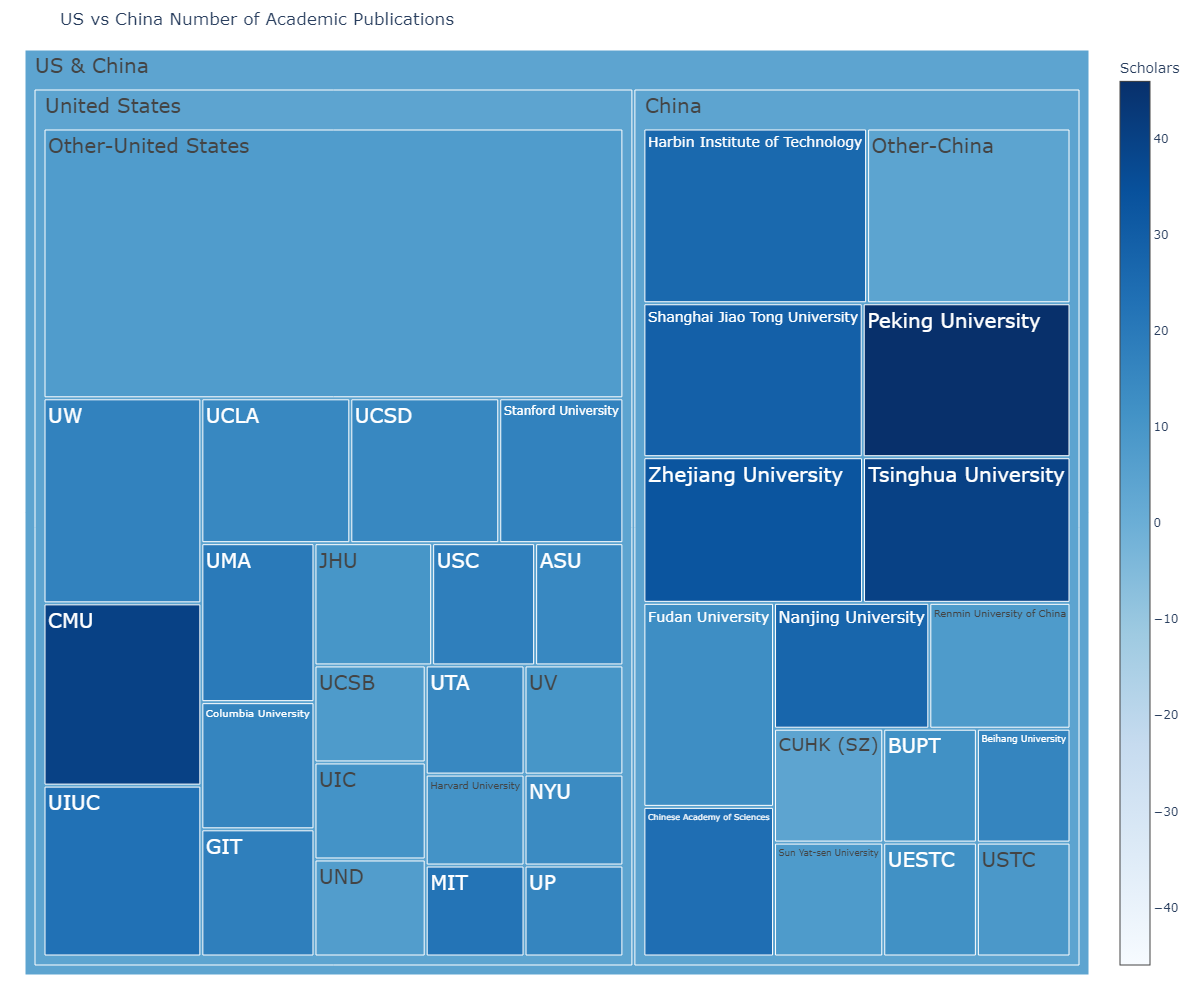

In [12]:
# Treeplot version I, the fontsize can be set
year = 2022
# To use this treeplot, we must set the parent and lable variables
df_scholar_number = df_csranking[df_csranking['name'].isin(df_cs_paper['author'])]\
    .groupby('affiliation').agg('count')['name'].sort_values(ascending = False)
df_treeplot1 = df_cs_paper[df_cs_paper['year'] == year]\
    .groupby(['country','university']).agg('count')['key'].reset_index()
df_treeplot1 = pd.merge(df_treeplot1.set_index('university'), df_scholar_number,
                        left_index = True, right_index = True).reset_index()
df_treeplot1.columns = ['university','country',	'key','name']
# Set non Top50 universities to be 'Other'
threshold_key = df_treeplot1.sort_values(by = 'key', ascending = False).iloc[50]['key']
df_treeplot1['university'][df_treeplot1['key'] < threshold_key] = 'Other'
# Get the abbreviation of universities
df_treeplot1['university'][(df_treeplot1['country'] == 'United States')&\
                           (df_treeplot1['university'].str.split().apply(len)>2)] = \
    df_treeplot1[df_treeplot1['country'] == 'United States']['university'].str.findall(r'[A-Z]').apply(lambda x: ''.join(x) )
#Filter for universities in the United States and China
df_treeplot1 = df_treeplot1[df_treeplot1['country'].isin(['United States','China'])]
df_treeplot2 = df_treeplot1.groupby(['country','university']).agg({'key':'sum','name':'mean'}).reset_index()

# Set the 'United States', 'China' and 'US & China' rows as it's needed by this treeplot
min_val = df_treeplot2['name'].min()
max_val = df_treeplot2['name'].max()
df_treeplot2['university'][(df_treeplot2['university']=='Other')&\
                           (df_treeplot2['country']=='China')] = 'Other-China'
df_treeplot2['university'][(df_treeplot2['university']=='Other')&\
                           (df_treeplot2['country']=='United States')] = 'Other-United States'
df_treeplot2_temp = df_treeplot2.groupby('country').agg('sum')
df_treeplot2['color'] = df_treeplot2['name']/max_val
df_treeplot2.loc[len(df_treeplot2)] = (['US & China', 'United States'] +
                                       [df_treeplot2_temp.loc['United States'].iloc[0]] + 
                                       [min_val, 0.25])
df_treeplot2.loc[len(df_treeplot2)] = (['US & China', 'China'] + 
                                       [df_treeplot2_temp.loc['China'].iloc[0]] + 
                                       [min_val, 0.25])
df_treeplot2.loc[len(df_treeplot2)] = (['', 'US & China'] + 
                                       [df_treeplot2_temp.loc['China'].iloc[0]+
                                        df_treeplot2_temp.loc['United States'].iloc[0]] + 
                                       [min_val,0.25])

# Draw the plot
fig = go.Figure(
    go.Treemap(
        labels = df_treeplot2['university'],
        parents=df_treeplot2['country'],
        values=df_treeplot2['key'],
        root_color="lightgrey",
        textfont_size=20,
        branchvalues='total',
        
        marker=dict(
        colors=df_treeplot2['name'],
        colorscale='Blues',
        cmid=0,
        cmax=max_val,
        colorbar=dict(
            title="Scholars",
            exponentformat='e'
        ),)
    ))
fig.update_layout(title = 'US vs China Number of Academic Publications', width=1000,height=1000,margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [13]:
# Generate the tree plot of the publications

# Generate the treemap

df_cs_paper1 = df_cs_paper.copy()
year = widgets.IntSlider(
    value=2022,
    min=2000,
    max=2022,
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


def plot_treemap(year):
    """Input: year, int, the selected year
    Output: Treemap of the publications and number of scholars"""

    
    # Generate the dataframe
    df_scholar_number = df_csranking[df_csranking['name'].isin(df_cs_paper['author'])]\
        .groupby('affiliation').agg('count')['name'].sort_values(ascending = False)
    df_treeplot1 = df_cs_paper[df_cs_paper['year'] == year]\
        .groupby(['country','university']).agg('count')['key'].reset_index()
    df_treeplot1 = pd.merge(df_treeplot1.set_index('university'), 
                            df_scholar_number,left_index = True, right_index = True).reset_index()
    df_treeplot1.columns = ['university','country',	'key','name']
    threshold_key = df_treeplot1.sort_values(by = 'key', ascending = False).iloc[50]['key']
    # Get the abbreviation of universities
    df_treeplot1['university'][(df_treeplot1['country'] == 'United States')&
                               (df_treeplot1['university'].str.split().apply(len)>2)] = \
        df_treeplot1[df_treeplot1['country'] == 'United States']['university'].str.findall(r'[A-Z]').apply(lambda x: ''.join(x) )
    # Set non Top50 universities to be 'Other'
    df_treeplot1['university'][df_treeplot1['key'] < threshold_key] = 'Other'
 
    # Plot the treemap
    df_treeplot1 = df_treeplot1[df_treeplot1['country'].isin(['United States','China'])]
    fig = px.treemap(df_treeplot1, path=['country', 'university'], values='key',
                     color='name', hover_data=['key'],
                     color_continuous_scale='blues',
                     color_continuous_midpoint=0, width=1080,
                     height=640, 
                     title='US vs China Number of Academic Publications')
    fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
    fig.show()


interact(plot_treemap, year=year);

interactive(children=(IntSlider(value=2022, continuous_update=False, description='Year:', max=2022, min=2000),…

### 4.2 The citations of each university

Text(0.5, 1.0, 'Citations among Universities')

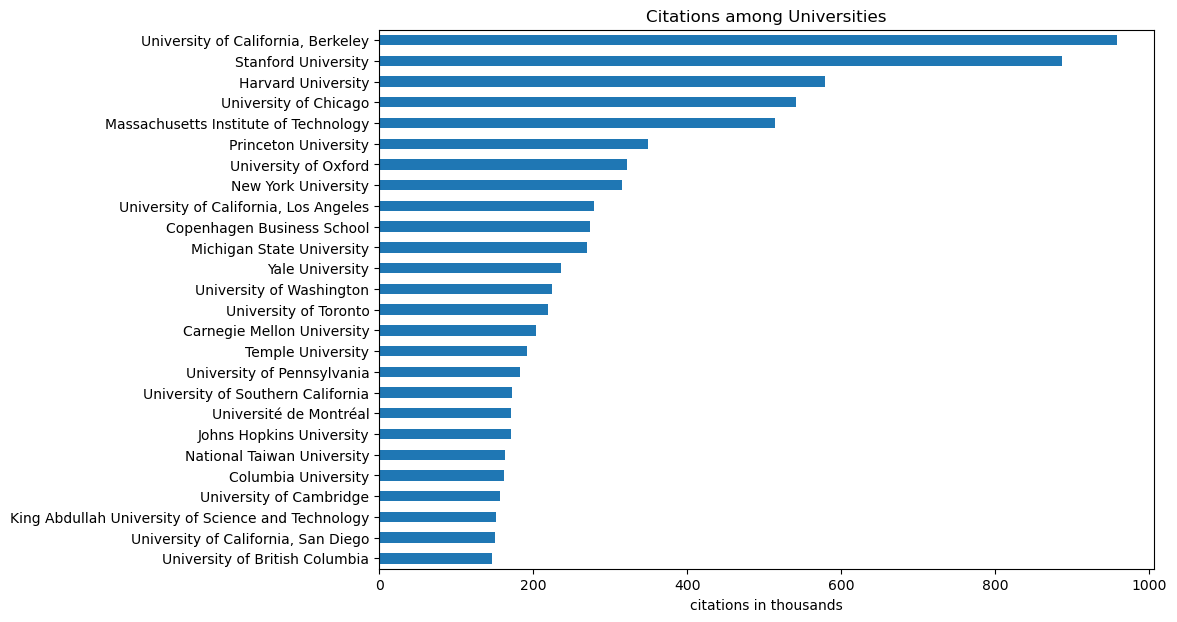

In [14]:
# Drop duplicate as there are mulitple authors for each publication
df_publications = df_publications.drop_duplicates(
    subset = 'publication_title', 
    keep = 'first', inplace = False)
fig, ax = plt.subplots(figsize=(10,7))
# Sum up the number of citations
df_publications['publication_num_citations1'] = df_publications['publication_num_citations']/1000
df_publications.dropna(subset = 'university').groupby('university').agg('sum')\
    ['publication_num_citations1'].sort_values(ascending = False)[25::-1].plot.barh(ax =ax)
ax.set_ylabel('');
ax.set_xlabel('citations in thousands')
ax.set_title('Citations among Universities')

The buble plot of universities in the United States

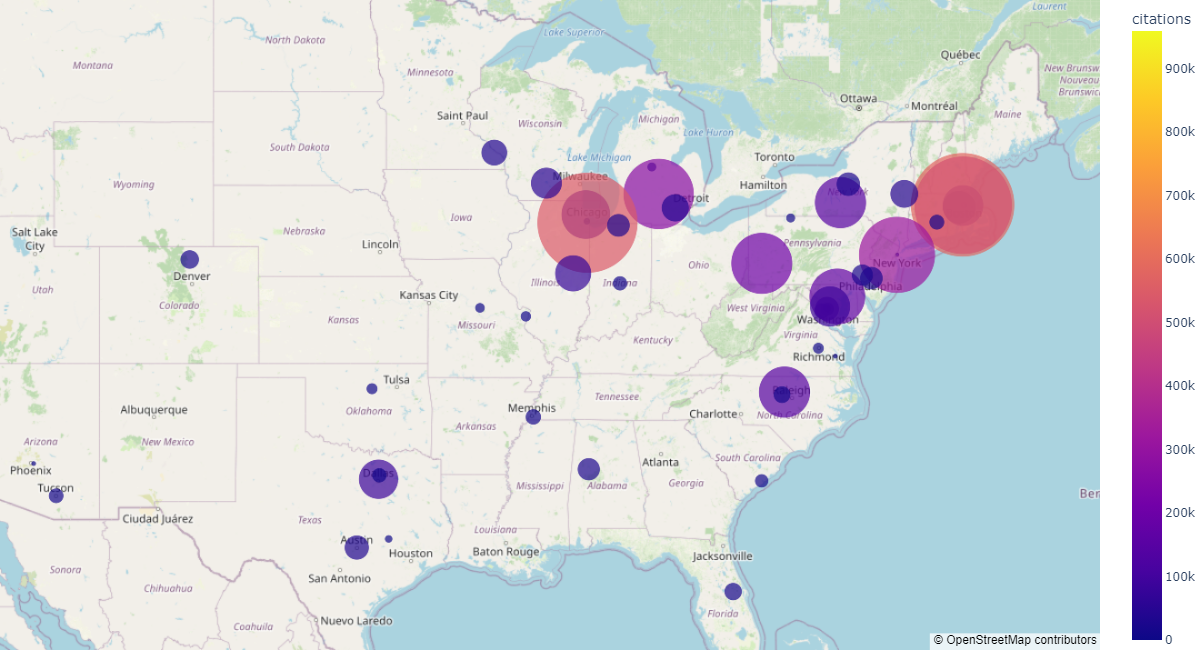

In [15]:
# The citations is stored in dict variable, we need to unstack them to get the citations per year.
df1 = df_publications.dropna(subset = ['university','publication_cites_per_year']).copy()
df1['publication_cites_per_year'] = df1['publication_cites_per_year'].astype(str)
df1['publication_cites_per_year'] = df1.publication_cites_per_year.agg(eval)
df1 = df1.reset_index()
df2 = pd.merge(df1, pd.DataFrame(df1['publication_cites_per_year'].values.tolist()), 
               right_index = True, left_index = True).fillna(0)
df3 = df2.groupby(by = 'university').agg('sum')

# manipulate the university name so that they can match in different datasets.
geo_university.drop_duplicates(subset = 'SCHOOL', keep = 'first', inplace = True)
geo_university['university'] = geo_university['SCHOOL']
geo_university['SCHOOL'] = geo_university['SCHOOL'].str.replace('[\W\s]','')\
    .str.lower().str.replace('the','')
df_total_citations = df_publications.dropna(subset = 'university')\
    .groupby('university').agg('sum')
df_total_citations['SCHOOL'] = df_total_citations.index.str.replace('[\W\s]','')\
    .str.lower().str.replace('the','')
for school in df_total_citations['SCHOOL']:
    if geo_university['SCHOOL'].str.contains(school).sum():
        if geo_university['SCHOOL'].str.contains(school).sum()>1:
            geo_university['SCHOOL'][geo_university['SCHOOL'].str.contains(school)] = school
geolocation1 = geolocation.copy() 
geolocation1['SCHOOL'] = geolocation1['institution'].copy()
geolocation1['SCHOOL'] = geolocation1['SCHOOL'].str.replace('Univ.','university', regex = False)\
    .str.replace('[\W\s]','').str.lower().str.replace('the','')

for school in df_total_citations['SCHOOL']:
    if geolocation1['SCHOOL'].str.contains(school).sum():
        if geolocation1['SCHOOL'].str.contains(school).sum()>1:
            geolocation1['SCHOOL'][geolocation1['SCHOOL'].str.contains(school)] = school

# Get the latitude and longitude of the universities.
df_total_citations = df_total_citations.set_index('SCHOOL')
geo_university = geo_university.drop_duplicates('SCHOOL')
geo_university = geo_university.set_index('SCHOOL')
df_bubble = pd.merge(df_total_citations, geo_university[['LOC_LAT','LOC_LONG', 'university']],
                     left_index = True, right_index=True)

# Draw the plot
df_bubble['citations'] = df_bubble['publication_num_citations']
fig = px.scatter_mapbox(df_bubble, lat = 'LOC_LAT', lon = 'LOC_LONG', size = 'citations',
                        zoom = 4,color = 'citations', mapbox_style = 'open-street-map',
                        height = 650, width = 1200, size_max=95, hover_name="university")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})                        
fig.show()

Text(0.5, 1.0, 'Citations of the Top 10 Universities in the US')

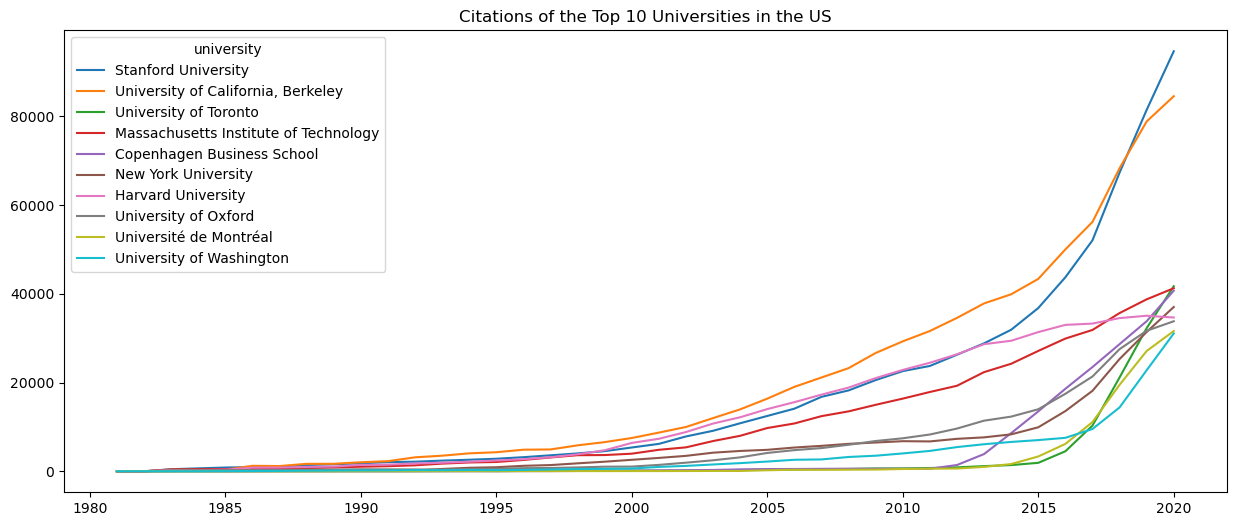

In [16]:
# Draw the time trends of top universities
fig,ax = plt.subplots(figsize=(15,6))

df4 = df3[range(1981,2021)].reset_index().groupby('university').agg('sum')
df4.sort_values(by = 2020, ascending = False)[:10].transpose().plot(ax = ax)
ax.set_title('Citations of the Top 10 Universities in the US')

### 4.3 The Original Work - Models

Text(0.5, 1.0, 'Histogram of the Models')

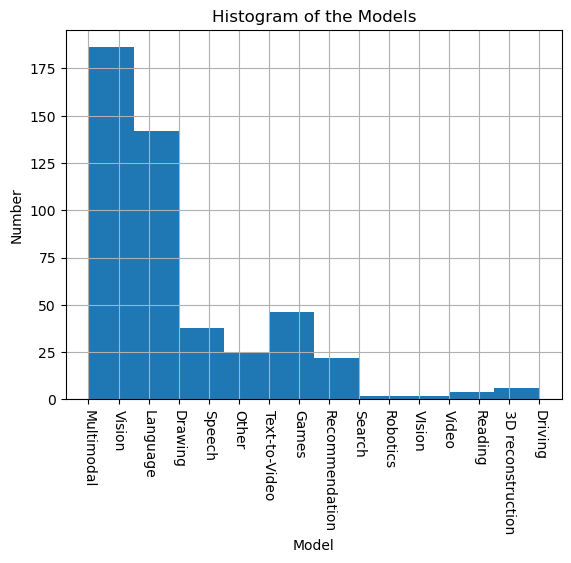

In [17]:
# Draw the histogram of models on domain
df_model_name1 = df_model_name.copy()
df_model_name1['Domain'].hist()
plt.xticks(rotation = 270);
plt.xlabel('Model')
plt.ylabel('Number')
plt.title('Histogram of the Models')

In [18]:
# Get the key words
# df_model_name = pd.read_excel('Parameter, Compute and Data Trends in Machine Learning.xlsx')
names = df_model_name.replace(regex = '\(.+\)', value = '')['System']\
    .replace(regex = '|v[\d\W]+|V[\d\W]+|-\d[\d\w]*| \d\.[\S\s]*| [\d ]+$|\++', value = '').unique()
df_model_name = df_model_name.set_index(['System',"Publication date", 'Organization Categorization'])\
    ["Organization(s)"].str.split(",", expand=True)\
    .stack().reset_index(drop=True, level=-1).reset_index().rename(columns={0: "Organization(s)"})
df_model_name['year'] = df_model_name['Publication date'].apply(lambda x: str(x)[:4])

The model dataset provides the names, dates, organizations, and organization categorizations of each important model, so we still need to find the country of each model. As nearly half of the models are built by companies, the dataset in publications cannot help us much. Though there are only 356 unique organizations in this dataset, the Nominatim cannot work correctly since large companies have branches worldwide, and it’s challenging to find the headquarters automatically.

We scrape the Bing search to get the country variable. If a question like “Which country is Google belongs to?” is asked, Bing will highlight the answer to the problem. Therefore, it’s easier to use libraries such as BeautifulSoup to get the answer. However, Bing cannot provide the country for each organization. It can answer where Google is, but it failed with Google Brain. We will replace the nan value if the organization name is contained by another organization name with a valid country variable. Finally, the country variables for all the organizations were successfully reconstructed.

In [19]:
# import time
# company_country_dict = dict()
# def get_country(row):
#     time.sleep(1)
#     headers = {
#         'User-agent':
#         'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.67 Safari/537.36'
#     }
#     s = row['Organization(s)']
#     print('https://www.bing.com/search?q=Which country is '+  s +' belongs?')
#     html = requests.get('https://www.bing.com/search?q=Which country is '+  s +' belongs?', headers=headers)
#     soup = BeautifulSoup(html.text, 'html.parser')
#     try:
#         if s in company_country_dict.keys():
#             return company_country_dict[s]
#         answer = soup.select('.b_focusTextMedium')
#         if answer == []:
#             answer = soup.select('.b_focusTextLarge')
#         answer = answer[0].text
#         company_country_dict[s] = answer
#         print(answer)
#         return answer
#     except:
#         return None

# # df_model_name['Country'].iloc[0:10]
# l = df_model_name.apply(get_country, axis = 1)


# df_model_name['country'] = l
# df_model_name['Organization(s)'][~df_model_name['country'].isna()]= df_model_name[~df_model_name['country'].isna()]['Organization(s)'].replace(r'^\s','', regex = True)
# replace_name_dict = dict(zip(df_model_name[~df_model_name['country'].isna()]['Organization(s)'], df_model_name[~df_model_name['country'].isna()]['country']))

# for k in replace_name_dict.keys():
#     df_model_name['Organization(s)'][df_model_name['country'].isna()].str.contains(k)
#     df_model_name['country'][df_model_name['country'].isna()] = replace_name_dict[k]
# df_model_name.to_csv('df_model_name_country.csv')

model_country_replace = {'American':'United States', 'Attica':'Greece', 'Canadian':'Canada', 'Chinese':'China', 'Danish':'Danmark',
       'England':'United Kingdom', 'England, United Kingdom':'United Kingdom',  'French':'France',
       'Hong Kong':'China', 'Italian':'Italy', 'London':'United Kingdom', 'Montreal':'Canada',
       'Montreal, Quebec':'Canada',  'New Jersey':'United States',
       'Quebec':'Canada', 'Russian':'Russia', 'Scotland':'United Kingdom',
       'Swiss':'Swedish', 'Taiwan':'China-Taiwan', 'The Czech Republic':'Czech',
       'The Netherlands':'Netherlands', "The People's Republic of China":'China', 'The U.S':'United States',
       'The US':'United States', 'The United Kingdom':'United Kingdom', 'The United States':'United States',
       "The United States's":'United States', 'U.S':'United States', 'U.S. state of South Carolina':'United States', 'US':'United States',
       'USA':'United States', 'United States of America':'United States',
       'Vienna, Austria':'Austria'}
df_model_name['country'] = temp_country['country'].replace(model_country_replace)

In [20]:
# Get the number of original work for each country.
years = [str(x) for x in range(1986,2023)]
df_model_name['year'] = df_model_name['Publication date'].apply(lambda x: str(x)[:4])
df_model_name_p = df_model_name.pivot_table(index = 'year',columns = 'country', 
                                            values = 'Organization(s)', aggfunc = 'count').fillna(0)
df_model_name_p.loc['total']  = df_model_name_p.sum()

Text(0.5, 1.0, 'Number of Important Models across the Globe')

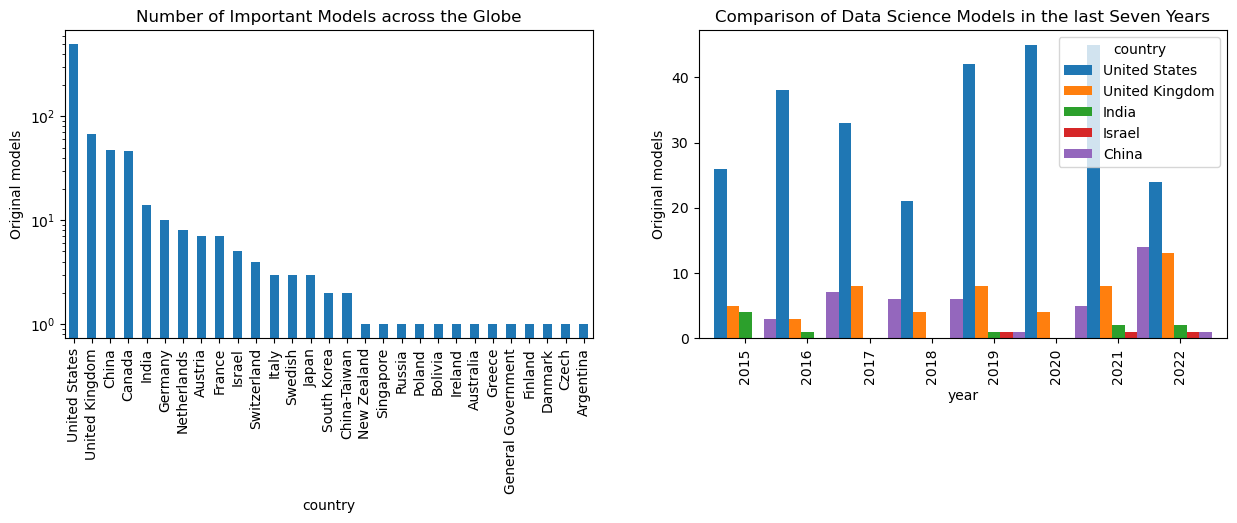

In [21]:
fig, axes = plt.subplots(1,2,figsize = (15,4))
years = [str(x) for x in range(2015,2023)]
ax = axes[1]
# Draw the plot of Top5 countries's models in different years
df_model_name_p.loc[years][df_model_name_p.loc['2022']\
                           .sort_values(ascending = False)[:5].index].plot.bar(ax = ax,width = 1)
ax.set_ylabel('Original models');
ax.set_title('Comparison of Data Science Models in the last Seven Years');
# Draw the plot of top 50 countries of models
ax = axes[0]
df_model_name_p.loc['total'][df_model_name_p.loc['total']\
                             .sort_values(ascending = False)[:50].index].plot.bar(ax = ax)
ax.set_yscale('log')
ax.set_ylabel('Original models');
ax.set_title('Number of Important Models across the Globe')


In [22]:
# The rank of universities
df_model_name.groupby('country').agg('count')\
    .sort_values(by = 'System', ascending = False)['Organization(s)'][0:15]

country
United States     496
United Kingdom     68
China              47
Canada             46
India              14
Germany            10
Netherlands         8
France              7
Austria             7
Israel              5
Swedish             3
Japan               3
Switzerland         4
South Korea         2
Singapore           1
Name: Organization(s), dtype: int64

In [23]:
# The trend of original work.
df_model_name_p.loc[years[-10:]].transpose()\
    .sort_values(by = '2022', ascending = False).iloc[:15]

year            2015  2016  2017  2018  2019  2020  2021  2022
country                                                       
United States   26.0  38.0  33.0  21.0  42.0  45.0  45.0  24.0
United Kingdom   5.0   3.0   8.0   4.0   8.0   4.0   8.0  13.0
India            4.0   1.0   0.0   0.0   1.0   0.0   2.0   2.0
Israel           0.0   0.0   0.0   0.0   1.0   0.0   1.0   1.0
China            3.0   7.0   6.0   6.0   1.0   5.0  14.0   1.0
Italy            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
Austria          0.0   1.0   1.0   0.0   0.0   2.0   2.0   0.0
Switzerland      0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0
Swedish          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
South Korea      0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0
Singapore        0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0
Russia           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
Poland           0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0
New Zealand      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
Netherlands      0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0

In [24]:
# The number of models in different organization categorizations
df_model_name\
    .groupby(['Organization Categorization']).agg('count')

System  Publication date  \
Organization Categorization                                                    
Academia                                               168               294   
Industry                                               206               241   
Industry - Academia Collaboration                       70               112   
Industry - Academia Collaboration (Academia Lea...       4                 4   
Industry - Academia Collaboration (Academia lea...      10                19   
Industry - Academia Collaboration (Industry Lea...       3                 3   
Industry - Academia Collaboration (Industry lea...      51                51   
Industry - Academia collaboration                        3                 3   
Non-profit                                               5                 5   
Research Collective                                      3                 3   
Research collective                                      1                 1   

                                                    Organization(s)  year  \
Organization Categorization                                                 
Academia                                                        294   294   
Industry                                                        241   241   
Industry - Academia Collaboration                               112   112   
Industry - Academia Collaboration (Academia Lea...                4     4   
Industry - Academia Collaboration (Academia lea...               19    19   
Industry - Academia Collaboration (Industry Lea...                3     3   
Industry - Academia Collaboration (Industry lea...               51    51   
Industry - Academia collaboration                                 3     3   
Non-profit                                                        5     5   
Research Collective                                               3     3   
Research collective                                               1     1   

                                                    country  
Organization Categorization                                  
Academia                                                294  
Industry                                                241  
Industry - Academia Collaboration                       112  
Industry - Academia Collaboration (Academia Lea...        4  
Industry - Academia Collaboration (Academia lea...       19  
Industry - Academia Collaboration (Industry Lea...        3  
Industry - Academia Collaboration (Industry lea...       51  
Industry - Academia collaboration                         3  
Non-profit                                                5  
Research Collective                                       3  
Research collective                                       1

In [25]:
# The number of original work in Top3 organization categorization 
years = [str(x) for x in range(1986,2023)]
df_model_name_ai = df_model_name.groupby(['Organization Categorization','year']).agg('count')
df_model_name_ai = df_model_name_ai.reset_index().pivot_table(
    index = 'Organization Categorization', columns = 'year', values = 'Organization(s)').fillna(0)
df_model_name_ai[years].iloc[:3]

year                               1986  1987  1988  1989  1990  1991  1992  \
Organization Categorization                                                   
Academia                            5.0   3.0   2.0   5.0   4.0   3.0   2.0   
Industry                            0.0   0.0   1.0   1.0   0.0   0.0   1.0   
Industry - Academia Collaboration   0.0   0.0   0.0   1.0   0.0   0.0   0.0   

year                               1993  1994  1995  ...  2013  2014  2015  \
Organization Categorization                          ...                     
Academia                            0.0   2.0   1.0  ...  15.0  20.0   6.0   
Industry                            1.0   0.0   3.0  ...   4.0   3.0  13.0   
Industry - Academia Collaboration   0.0   0.0   0.0  ...   8.0  14.0  13.0   

year                               2016  2017  2018  2019  2020  2021  2022  
Organization Categorization                                                  
Academia                           19.0  17.0  11.0   6.0  18.0   5.0   2.0  
Industry                           16.0  17.0  15.0  29.0  30.0  41.0  34.0  
Industry - Academia Collaboration  14.0  11.0   9.0   4.0   9.0   5.0   0.0  

[3 rows x 37 columns]

### 4.4 The key word of the publications in different countries

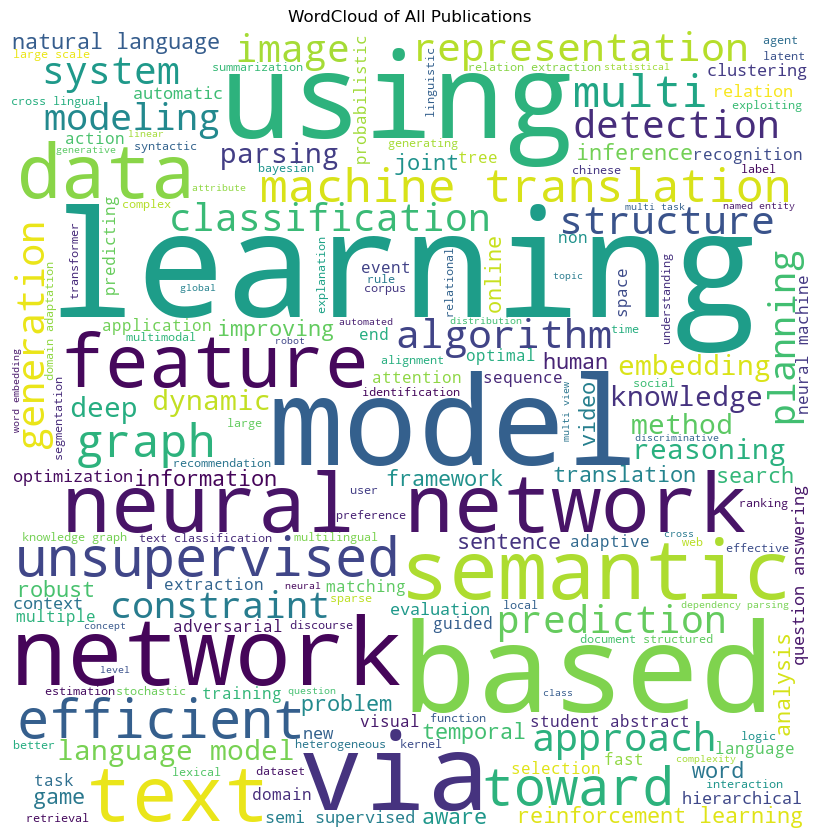

In [26]:
# Use word cloud to find the key words.
# Set stop words 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the CSranking paper title
for val in df_cs_paper['title']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud= WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('WordCloud of All Publications')
plt.show()

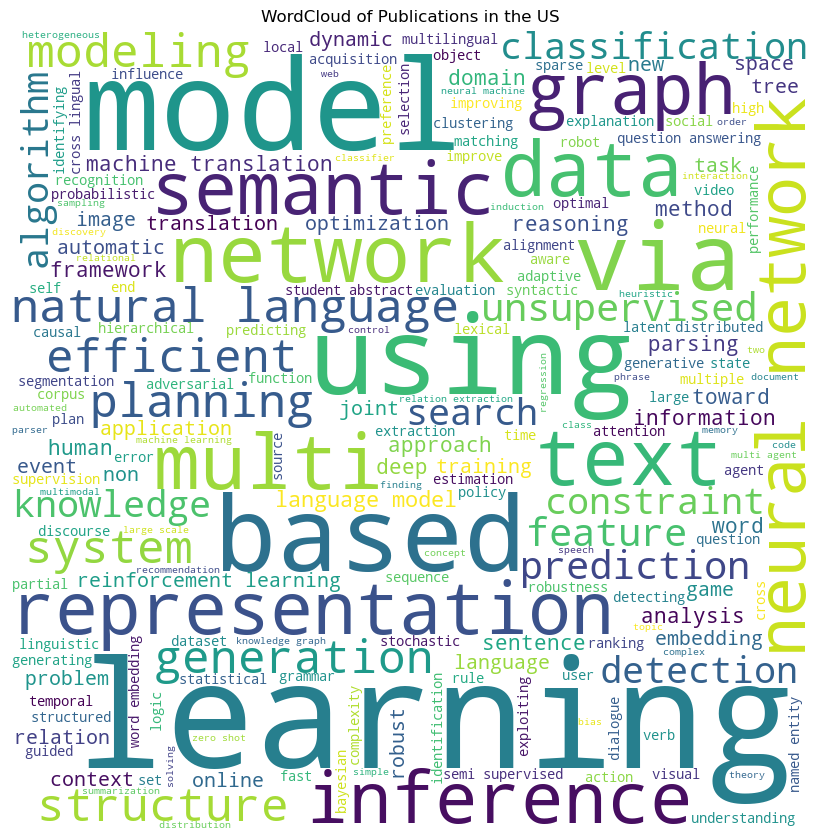

In [27]:
comment_words = ''


# iterate through the CSranking paper title of United States
for val in df_cs_paper['title'][df_cs_paper['country'] == 'United States']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud_US= WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_US)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('WordCloud of Publications in the US')
plt.show()

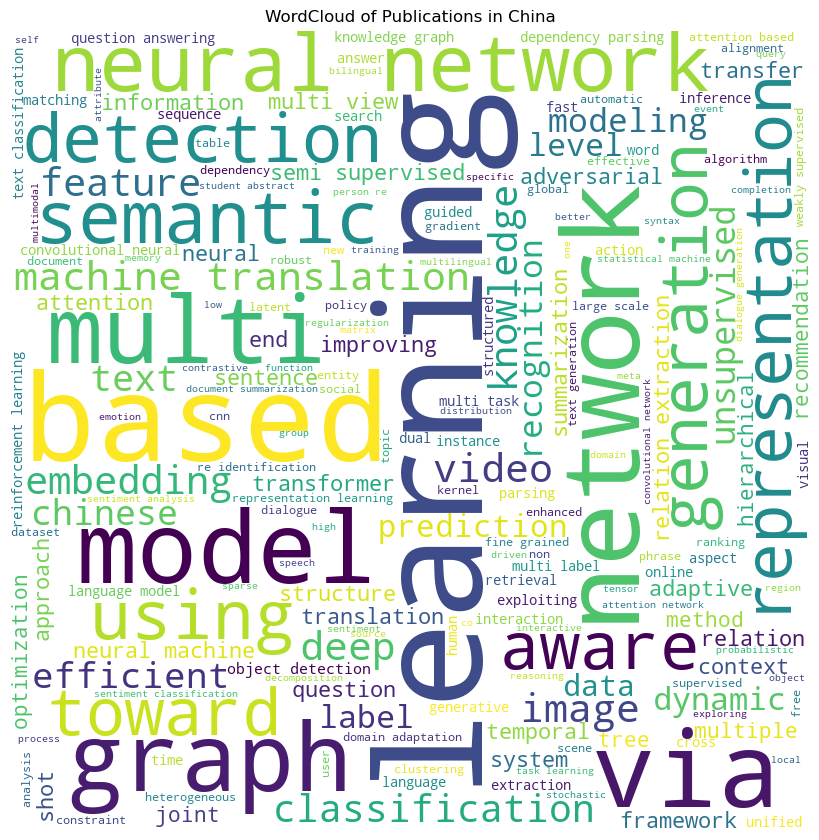

In [28]:
comment_words = ''
# iterate through the CSranking paper title of China
for val in df_cs_paper['title'][df_cs_paper['country'] == 'China']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud_CN = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_CN)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('WordCloud of Publications in China')
plt.show()

In [29]:
# Find the words and their corresponding weights of the publications' keywords
df_words_us = pd.DataFrame.from_dict(wordcloud_US.words_, orient='index', dtype=None, columns=None)
df_words_us.columns = ['weights']
df_words_cn = pd.DataFrame.from_dict(wordcloud_CN.words_, orient='index', dtype=None, columns=None)
df_words_cn.columns = ['weights']

In [30]:
# Find the most different word between US and China
(df_words_us - df_words_cn).dropna().sort_values('weights', ascending = False)[:10]

weights
using       0.263766
model       0.242171
inference   0.104718
algorithm   0.092581
data        0.092161
constraint  0.082966
search      0.080890
reasoning   0.078263
analysis    0.076187
domain      0.072798

In [31]:
# Find the most different word between US and China
(df_words_cn - df_words_us).dropna().sort_values('weights', ascending = False)[:10]

weights
network         0.239018
graph           0.200898
based           0.183796
multi           0.146149
video           0.143889
neural network  0.142444
aware           0.139843
via             0.123503
image           0.089244
neural machine  0.083360

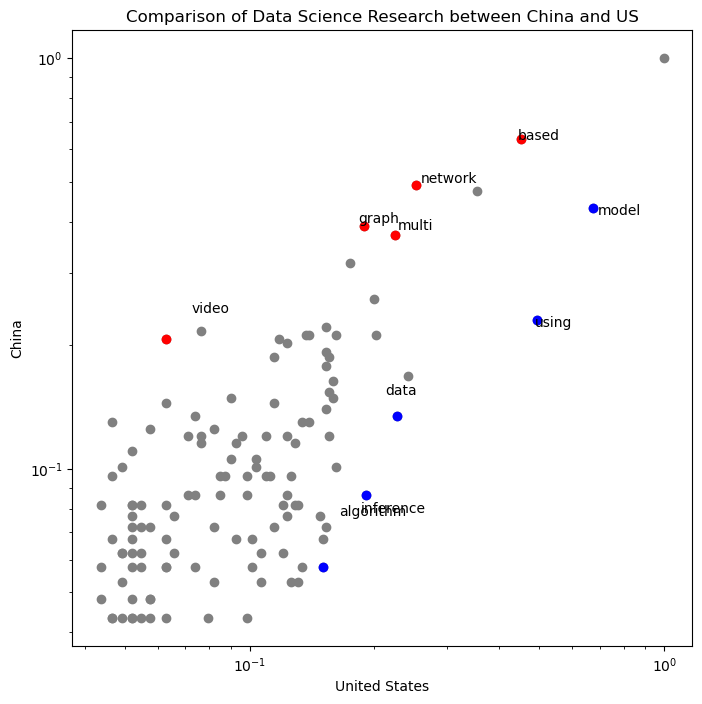

In [32]:
#Draw the scatter plot where the words' weights in US and China are shown in the x and y axis.
word_us_cn = pd.merge(df_words_us, df_words_cn, left_index = True, right_index = True).dropna()
word_us_cn.columns = ['United States', 'China']
word_us_cn['difference'] = word_us_cn['United States'] - word_us_cn['China']
word_us_cn = word_us_cn.sort_values(by = 'difference', ascending = False)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter((word_us_cn['United States']), (word_us_cn['China']), color = 'grey')
ax.set_yscale('log')
ax.set_xscale('log')

for i in range(5):
    row = word_us_cn.iloc[i]
    ax.scatter(row['United States'], row['China'], color = 'blue')
    ax.text(row['United States']+ np.random.uniform(-0.02, 0.02), row['China']
            + np.random.uniform(-0.02, 0.02), row.name)
    row = word_us_cn.iloc[-i-1]
    ax.scatter(row['United States'], row['China'], color = 'red')
    ax.text(row['United States']+ np.random.uniform(-0.01, 0.04), row['China']
            + np.random.uniform(-0.01, 0.04), row.name)

ax.set_xlabel('United States')
ax.set_ylabel('China');
ax.set_title('Comparison of Data Science Research between China and US');

# 5 Dependencies

In [33]:
try:
    %load_ext watermark
    %watermark -v -m -p pandas,numpy,matplotlib,geopy,requests,xml,ipywidgets,plotly,wordcloud,bs4
except:
    !pip install watermark

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

pandas    : 1.5.3
numpy     : 1.23.5
matplotlib: 3.5.2
geopy     : 2.3.0
requests  : 2.28.1
xml       : unknown
ipywidgets: 7.6.5
plotly    : 5.13.1
wordcloud : 1.9.1.1
bs4       : 0.0.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 151 Stepping 2, GenuineIntel
CPU cores   : 20
Architecture: 64bit

